
# Loan Approval Prediction — Pipeline Notebook

### Introduction
This notebook implements a reproducible ML pipeline for loan approval prediction: preprocessing, training, evaluation,
and serialization of model artifacts for deployment (model, scaler, encoders).

**Artifacts saved:** `model.pkl`, `scaler.pkl`, `encoder.pkl` (if applicable)
---


# Loan Approval Prediction — ML Pipeline Notebook

**Goal:** Build a reproducible ML pipeline (preprocessing → model → tuning → save) for the Loan Approval classification task.

In [1]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)

RANDOM_STATE = 42
DATA_PATH ="../data/train.csv" 
sns.set(style='whitegrid')

## Load data

In [2]:
# Load dataset
df = pd.read_csv(DATA_PATH)
# minimal target mapping and dependents fix
df = df.copy()
df['Loan_Status'] = df['Loan_Status'].map({'Y':1,'N':0})
if 'Dependents' in df.columns:
    df['Dependents'] = df['Dependents'].replace('3+', 3)
    df['Dependents'] = pd.to_numeric(df['Dependents'], errors='coerce')

print('Loaded:', df.shape)

Loaded: (614, 13)


## X and y and column types


In [3]:
# Drop identifier if present
if 'Loan_ID' in df.columns:
    df = df.drop(columns=['Loan_ID'])

y = df['Loan_Status']
X = df.drop(columns=['Loan_Status'])

# Detect columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print('Numeric cols:', numeric_cols)
print('Categorical cols:', cat_cols)

Numeric cols: ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical cols: ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']


## Build preprocessing pipelines
Numeric: median imputation + scaling (useful for linear models).  
Categorical: mode imputation + one-hot encoding.  
We combine them with `ColumnTransformer`.

In [5]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

print('Preprocessor ready')

Preprocessor ready


## Define pipeline with classifier placeholder
We create a pipeline containing preprocessing and a classifier. We'll tune RandomForest via GridSearch.

In [6]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

print(pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Dependents',
                                                   'ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                

## Train-test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE) #Use stratify to preserve class ratios
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (491, 11) Test: (123, 11)


## Quick cross-validation on training set
This gives a baseline for how the pipeline performs before tuning.

In [8]:
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
print('CV scores:', np.round(cv_scores,4))
print('CV mean:', cv_scores.mean())

CV scores: [0.7475 0.8061 0.8061 0.7143 0.7653]
CV mean: 0.7678622964337251


## GridSearchCV (small grid)
We tune a small set of Random Forest hyperparameters to keep compute low.

In [9]:
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 6, 12],
    'clf__min_samples_leaf': [1, 3]
}

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print('Best params:', grid.best_params_)
print('Best CV score:', grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}
Best CV score: 0.7942665469599482


## Evaluate best model on test set
We print common metrics and show a confusion matrix.

Test Accuracy: 0.8455284552845529
Precision: 0.83
Recall: 0.9764705882352941
F1: 0.8972972972972973
ROC-AUC: 0.8219814241486069

Classification Report:
               precision    recall  f1-score   support

           0     0.9130    0.5526    0.6885        38
           1     0.8300    0.9765    0.8973        85

    accuracy                         0.8455       123
   macro avg     0.8715    0.7646    0.7929       123
weighted avg     0.8557    0.8455    0.8328       123



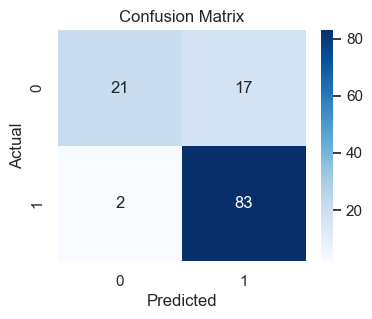

In [10]:
best_pipe = grid.best_estimator_

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:,1] if hasattr(best_pipe, 'predict_proba') else None

print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, zero_division=0))
print('Recall:', recall_score(y_test, y_pred, zero_division=0))
print('F1:', f1_score(y_test, y_pred, zero_division=0))
if y_proba is not None:
    print('ROC-AUC:', roc_auc_score(y_test, y_proba))

print('\nClassification Report:\n', classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

## Saving the best pipeline

In [12]:
joblib.dump(best_pipe, 'loan_pipeline_v1.joblib')
print('Pipeline saved to loan_pipeline_v1.joblib')

Pipeline saved to loan_pipeline_v1.joblib


The final trained pipeline is saved as a .joblib file, ready for deployment or batch prediction.


### Artifact: `loan_pipeline_v1.joblib`
This notebook saves a **single** joblib file `loan_pipeline_v1.joblib` that contains the full preprocessing pipeline and model (scaler/encoders + estimator).
This is convenient for deployment: the FastAPI app will load this file and call `pipeline.predict()` directly on a DataFrame of inputs.

In [ ]:

# Save the full preprocessing+model pipeline as a single joblib file
import joblib, os

if os.path.exists("loan_pipeline_v1.joblib"):
    print("Found existing 'loan_pipeline_v1.joblib' in the working directory. Using that file for deployment.")
else:
    saved = False
    # Try common pipeline variable names in order
    candidates = ["loan_pipeline_v1", "loan_pipeline", "pipeline", "model", "best_model"]
    for name in candidates:
        try:
            obj = globals()[name]
            joblib.dump(obj, "loan_pipeline_v1.joblib")
            print(f"Saved pipeline object from variable '{name}' to loan_pipeline_v1.joblib")
            saved = True
            break
        except KeyError:
            continue
        except Exception as e:
            print(f"Attempted to save variable '{name}' but got: {e}")
    if not saved:
        print("Could not find a pipeline variable to save. If you've already saved 'loan_pipeline_v1.joblib' earlier, ensure it's in this folder. Otherwise, assign your trained pipeline object to one of these variable names and re-run this cell:")
        print(candidates)



---
### Conclusions & Deployment Notes (Pipeline)
- The pipeline trains and evaluates the model and saves artifacts needed for deployment (model.pkl, scaler.pkl, encoder.pkl).
- To deploy: use these artifacts with a FastAPI app and Streamlit demo.
---
